# LASSO regression on the Ames housing dataset

This notebook accompanies the Kx whitepaper on using embedPy to explore a regression problem using the Ames Housing Dataset compiled by Dean De Cock for use in data science and statistical modelling education.

### Data cleaning and pre-processing

After loading the data rename any columns starting with numbers to avoid issues when attempting to query or modify. Note that if this is executed from a directory not containing the train.csv file of the data, the file's path will need to be corrected.

In [91]:
train:("IISIISSSSSSSSSSSSIIIISSSSSISSSSSSSISIIISSSSIIIIIIIIIISISISSISIISSSIIIIIISSSIIISSF";enlist csv)0:`:train.csv
train:@[cols train;where cols[train] in `1stFlrSF`2ndFlrSF`3SsnPorch;:;`firFlrSF`secFlrSF`threeSsnPorch] xcol train

SalePrice is our target value for the model to train against, log creates a simpler relationship

In [92]:
update SalePrice:log SalePrice from `train;
y:train.SalePrice;

Some data cleanup to check for duplicates and remove obvious outliers

In [93]:
count[train]~count exec distinct Id from train

1b


In [94]:
delete Id from `train;
delete from `train where GrLivArea > 4000;

Dynamically update nulls from 'NA' to either 'No' or 'None'

In [95]:
updateNulls:{[t]
  noneC:`Alley`MasVnrType;
  noC:`BsmtQual`BsmtCond`BsmtExposure`BsmtFinType1`BsmtFinType2`Fence`FireplaceQu;
  noC,:`GarageType`GarageFinish`GarageQual`GarageCond`MiscFeature`PoolQC;
  a:raze{y!{(?;(=;enlist`NA;y);enlist x;y)}[x;]each y}'[`None`No;(noneC;noC)];
  ![t;();0b;a]
 }

train:updateNulls train

Convert numerical features into categorical features. This will be used later when encoding these fields.

In [96]:
monthDict:(1+til 12)!`Jan`Feb`Mar`Apr`May`Jun`Jul`Aug`Sep`Oct`Nov`Dec;
@[`train;`MoSold;monthDict];
subclDict:raze {enlist[x]!enlist[`$"SC",string[x]]}each 20 30 40 45 50 60 70 75 80 85 90 120 160 180 190;
@[`train;`MSSubClass;subclDict];

As above, but categorical to numerical.

In [97]:
@[`train;;`None`Grvl`Pave!til 3] each `Alley`Street;
@[`train;;`No`Po`Fa`TA`Gd`Ex!til 6] each `BsmtCond`BsmtQual`ExterCond`ExterQual`FireplaceQu`GarageCond`GarageQual`HeatingQC`KitchenQual;
@[`train;`BsmtExposure;`No`Mn`Av`Gd!til 4];
@[`train;;`No`Unf`LwQ`Rec`BLQ`ALQ`GLQ!til 7] each `BsmtFinType1`BsmtFinType2;
@[`train;`Functional;`Sal`Sev`Maj2`Maj1`Mod`Min2`Min1`Typ!1+til 8];
@[`train;`LandSlope;`Sev`Mod`Gtl!1+til 3];
@[`train;`LotShape;`IR3`IR2`IR1`Reg!1+til 4];
@[`train;`PavedDrive;`N`P`Y!til 3];
@[`train;`PoolQC;`No`Fa`TA`Gd`Ex!til 5];
@[`train;`Utilities;`ELO`NoSeWa`NoSewr`AllPub!1+til 4];

### Feature engineering

Simplify some existing features to reduce their scope.

In [98]:
{![`train;();0b;enlist[`$"Simpl",string[x]]!enlist (((1+til 10)!1 1 1 2 2 2 3 3 3 3);x)]} each `OverallQual`OverallCond`GarageCond`GarageQual`FireplaceQu`KitchenQual`HeatingQC`BsmtFinType1`BsmtFinType2`BsmtCond`BsmtQual`ExterCond`ExterQual;
{![`train;();0b;enlist[`$"Simpl",string[x]]!enlist (((1+til 8)!1 1 2 2 3 3 3 4);x)]} each `PoolQC`Functional;

Combining features that are very similar to each other

In [99]:
gradeFuncPrd:{[t;c1;c2;cNew]![t;();0b;enlist[`$string[cNew]]!enlist (*;c1;c2)]}

In [100]:
combineFeat1:`OverallQual`GarageQual`ExterQual`KitchenAbvGr,
    `Fireplaces`GarageArea`PoolArea`SimplOverallQual`SimplExterQual,
    `PoolArea`GarageArea`Fireplaces`KitchenAbvGr;
combineFeat2:`OverallCond`GarageCond`ExterCond`KitchenQual,
    `FireplaceQu`GarageQual`PoolQC`SimplOverallCond`SimplExterCond,
    `SimplPoolQC`SimplGarageQual`SimplFireplaceQu`SimplKitchenQual;
combineFeat3:`OverallGrade`GarageGrade`ExterGrade`KitchenScore,
    `FireplaceScore`GarageScore`PoolScore`SimplOverallGrade`SimplExterGrade,
    `SimplPoolScore`SimplGarageScore`SimplFireplaceScore`SimplKitchenScore;

train:train{gradeFuncPrd[x;]. y}/flip(combineFeat1; combineFeat2; combineFeat3);

In [101]:
update TotalBath:BsmtFullBath+FullBath+0.5*BsmtHalfBath+HalfBath,
  AllSF:GrLivArea+TotalBsmtSF,
  AllFlrsSF:firFlrSF+secFlrSF,
  AllPorchSF:OpenPorchSF+EnclosedPorch+threeSsnPorch+ScreenPorch,
  HasMasVnr:((`BrkCmn`BrkFace`CBlock`Stone`None)!((4#1),0))[MasVnrType],
  BoughtOffPlan:((`Abnorml`Alloca`AdjLand`Family`Normal`Partial)!((5#0),1))[SaleCondition]
 from `train;

Find features that have a positive relationship with the Sale Price of the houses (our target to train against).

In [102]:
corr:desc raze {enlist[x]!enlist train.SalePrice cor ?[train;();();x]} each exec c from meta[train] where not t="s";

In [103]:
10#`SalePrice _corr // Top 10 most relevant features

OverallQual     | 0.8192401
AllSF           | 0.8172716
AllFlrsSF       | 0.729421
GrLivArea       | 0.7188441
SimplOverallQual| 0.7079335
ExterQual       | 0.6809463
GarageCars      | 0.6804076
TotalBath       | 0.6729288
KitchenQual     | 0.6671735
GarageScore     | 0.6568215


Create new polynomial features out of the above results.

In [104]:
polynom:{[t;c]
  a:raze(!).'({`$string[x],/:("_2";"_3";"_sq")};{((xexp;x;2);(xexp;x;3);(sqrt;x))})@\:/:c;
  ![t;();0b;a]
 }

train:polynom[train;key 10#`SalePrice _corr];

### Categorical and numerical features

Start by splitting the data into numerical and categorical tables.

In [105]:
.feat.categorical:?[train;();0b;]{x!x} exec c from meta[train] where t="s";
.feat.numerical:?[train;();0b;]{x!x} (exec c from meta[train] where not t="s") except `SalePrice;

In the numerical data all nulls are filled with the median value of that feature. Bring outliers back in line using scipy's stats module.

In [106]:
![`.feat.numerical;();0b;{x!{(^;(med;x);x)}each x}cols .feat.numerical];
skew:.p.import[`scipy.stats;`:skew];
skewness:{skew[x]`}each flip .feat.numerical;
@[`.feat.numerical;where abs[skewness]>0.5;{log[1+x]}];

One-hot encoding the categorical features and combining the result with the above numerical features creates a numerical only representation of the cleaned and processed data set.

In [107]:
oneHot:{[pvt;t;clm]
  t:?[t;();0b;{x!x}enlist[clm]];
  prePvt:![t;();0b;`name`true!(($;enlist`;((/:;,);string[clm],"_";($:;clm)));1)];
  pvtCol:asc exec distinct name from prePvt;
  pvtTab:0^?[prePvt;();{x!x}enlist[clm];(#;`pvtCol;(!;`name;`true))];
  pvtRes:![t lj pvtTab;();0b;enlist clm];$[()~pvt;pvtRes;pvt,'pvtRes]
 }

train:.feat.numerical,'()oneHot[;.feat.categorical;]/cols .feat.categorical;

In [108]:
select distinct t from meta train

t
-
f
j


Take random samples from the data set and create 2 sets for comparison in the model.

In [109]:
trainIdx:-1019?exec i from train;
X_train:train[trainIdx];
yTrain:y[trainIdx];
X_test:train[(exec i from train) except trainIdx];
yTest:y[(exec i from train) except trainIdx];

Standardize the features in the dataset that came from the numerical features table.

In [110]:
stdSc:{(x-avg x) % dev x};
@[`X_train;;stdSc] each cols .feat.numerical;
@[`X_test;;stdSc] each cols .feat.numerical;

Transform the kdb+ tables into python readable matrices.

In [111]:
xTrain:flip value flip X_train;
xTest:flip value flip X_test;

### Modelling

Using embedPy import the different modules which will be used to create a LASSO regresion model using the processed and cleaned data.

In [112]:
pd:.p.import`pandas;
np:.p.import`numpy;
cross_val_score:.p.import[`sklearn.model_selection;`:cross_val_score];
qLassoCV:.p.import[`sklearn.linear_model;`:LassoCV];

Numpy arrays of the data are created for using in training the model.

In [113]:
arrayTrainX:np[`:array][0^xTrain];
arrayTrainY:np[`:array][yTrain];
arrayTestX:np[`:array][0^xTest];
arrayTestY:np[`:array][yTest];

Create the LASSO model using a range of possible alphas and then fit the model to the Train data sets.

In [114]:
qLassoCV:qLassoCV[`alphas pykw 0.0001 0.0003 0.0006 0.001 0.003 0.006 0.01 0.03 0.06 0.1 0.3 0.6 1; `max_iter pykw 50000; `cv pykw 10; `tol pykw 0.1]
qLassoCV[`:fit][arrayTrainX;arrayTrainY];
alpha:qLassoCV[`:alpha_]`;
alpha

0.01


Investigate the mean squared error of the model. An average of the outputs from cross-validation that is close to 0 is good.

In [115]:
crossValScore:.p.import[`sklearn;`:model_selection;`:cross_val_score];
mseCV:{crossValScore[qLassoCV;x;y;`scoring pykw `neg_mean_squared_error]`};
avg mseCV[np[`:array][0^xTrain];np[`:array][yTrain]]

-0.1341472


We see the majority of the features end up having a zero coefficient.

In [116]:
count where 0=value impCoef:desc cols[train]!qLassoCV[`:coef_]`

284


In [117]:
(5#impCoef),-5#impCoef

KitchenQual      | 0.02729668
TotalBath_2      | 0.02027015
TotalBsmtSF      | 0.02016371
GrLivArea        | 0.01909559
ExterCond        | 0.01870187
BsmtFinType2     | -0.01210927
EnclosedPorch    | -0.01323461
Street           | -0.0150496
SimplKitchenScore| -0.01514494
LandSlope        | -0.02150008


Finally run the predictor against the other data set and compare results of the two in a matplotlib chart.

In [118]:
lassoTest:qLassoCV[`:predict][arrayTestX]

In [119]:
qplt:.p.import[`matplotlib.pyplot];
ptrain:qLassoCV[`:predict][arrayTrainX];
ptest:qLassoCV[`:predict][arrayTestX];
qplt[`:scatter][ptrain`;yTrain;`c pykw "blue";`marker pykw "s";`label pykw "Training Data"];
qplt[`:scatter][ptest`;yTest;`c pykw "lightgreen";`marker pykw "s";`label pykw "Validation Testing Data"];
qplt[`:title]"Linear regression with Lasso regularization";
qplt[`:xlabel]"Predicted values";
qplt[`:ylabel]"Real values";
qplt[`:legend]`loc pykw "upper left";
bounds:({floor min x};{ceiling max x})@\:/:raze each((ptrain`;ptest`);(yTrain;yTest));
bounds:4#bounds first idesc{abs x-y}./:bounds;
qplt[`:axis]bounds;

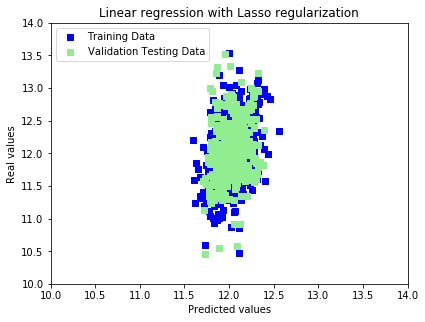

In [120]:
qplt[`:show][];